# Benchmark creation with [Polaris](https://github.com/polaris-hub/polaris)
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset (which has been demonstrated in <01_polaris_adme-fang-1_data_curation.ipynb>), and all necessary information about the dataset such as data source, description of endpoints, units etc. 

The resulting benchmarks can be found in Polaris:
- [biogen/adme-fang-hclint-1](https://polarishub.io/benchmarks/biogen/adme-fang-hclint-1)
- [biogen/adme-fang-rclint-1](https://polarishub.io/benchmarks/biogen/adme-fang-rclint-1)
- [biogen/adme-fang-perm-1](https://polarishub.io/benchmarks/biogen/adme-fang-perm-1)
- [biogen/adme-fang-hppb-1](https://polarishub.io/benchmarks/biogen/adme-fang-hppb-1)
- [biogen/adme-fang-rppb-1](https://polarishub.io/benchmarks/biogen/adme-fang-rppb-1)
- [biogen/adme-fang-solu-1](https://polarishub.io/benchmarks/biogen/adme-fang-solu-1)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import datamol as dm
import numpy as np

# polaris benchmark
from polaris.benchmark import SingleTaskBenchmarkSpecification

# polaris hub
from polaris.cli import PolarisHubClient
from polaris.utils.types import HubOwner

# utils
root = pathlib.Path("__file__").absolute().parents[3]
os.chdir(root)
sys.path.insert(0, str(root))
from utils.docs_utils import load_readme

In [2]:
# Get the owner and organization
org = "biogen"
data_name = "fang2023_ADME"

dirname = dm.fs.join(root, f"org-{org}", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/{data_name}"


owner = HubOwner(slug=org, type="organization")
owner

BENCHMARK_DIR = f"{gcp_root}/benchmarks"
DATASET_JSON = "gs://polaris-public/polaris-recipes/org-biogen/fang2023_ADME/datasets/adme-fang-v1/dataset.json"

FIGURE_DIR = f"{gcp_root}/figures"

## Load existing Dataset
> **Attention:** \
> See more dataset creataion details in [02_polaris_adme-fang_dataset.ipynb](https://github.com/polaris-hub/polaris-recipes/org-Biogen/fang2023_ADME/02_polaris_adme-fang_dataset.ipynb).

In [3]:
# Load the saved Dataset
from polaris.dataset import Dataset

dataset = Dataset.from_json(DATASET_JSON)

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test splits, and defining evaluation metrics to establish a baseline performance level.

### Create single task benchmarks from Fang2023 et al.
The tasks use the same test sets as in the Fang2023 paper. Here, we create a single task benchmark for each of the six ADME endpoints. The test set was created based on the train and test split provided in [this repository](https://github.com/molecularinformatics/Computational-ADME/tree/main/MPNN).

In [12]:
# Specify names and extract the test set from their dataset
endpoints = {
    "HLM": "HLM_CLint",
    "RLM": "RLM_CLint",
    "hPPB": "HPPB",
    "rPPB": "RPPB",
    "MDR1_ER": "MDR1-MDCK_ER",
    "Sol": "SOLUBILITY",
}

_endpoint = list(endpoints.keys())
INDIR = "gs://polaris-public/polaris-recipes/org-biogen/fang2023_ADME/raw/MPNN"

table = dataset.table

<div class="alert alert-block alert-warning"> <b>Attention:</b> We have noticed a set of molecules which have activity in MPNN folder, have no values in the `https://github.com/molecularinformatics/Computational-ADME/blob/main/ADME_public_set_3521.csv` file. We exclude the these molecules from splits to avoid confusion.</div>

In [13]:
split_key = "fang2023split"
paper_splits = {}
for endpoint in _endpoint:
    trainset = dm.read_csv(f"{INDIR}/ADME_{endpoint}_train.csv")
    testset = dm.read_csv(f"{INDIR}/ADME_{endpoint}_test.csv")
    train = table.query(
        f"`SMILES` in @trainset.smiles  & `{'LOG_'+endpoints[endpoint]}`.notna() "
    ).index.values
    test = table.query(
        f"`SMILES` in @testset.smiles  & `{'LOG_'+endpoints[endpoint]}`.notna() "
    ).index.values

    # check the intersections:
    intersection = set(train).intersection(set(test))
    if len(intersection) > 0:
        print(
            f"{endpoint} - Molecules {intersection} are in both training and test set"
        )
        # remove the molecules from trainig set
        train = np.array(list(set(train) - intersection))

    paper_splits[endpoints[endpoint]] = train, test

hPPB - Molecules {2689, 1417} are in both training and test set
rPPB - Molecules {2856, 1417, 473} are in both training and test set
MDR1_ER - Molecules {460} are in both training and test set


### Check distribution of train/test set in the chemical space

  0%|          | 0/3521 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


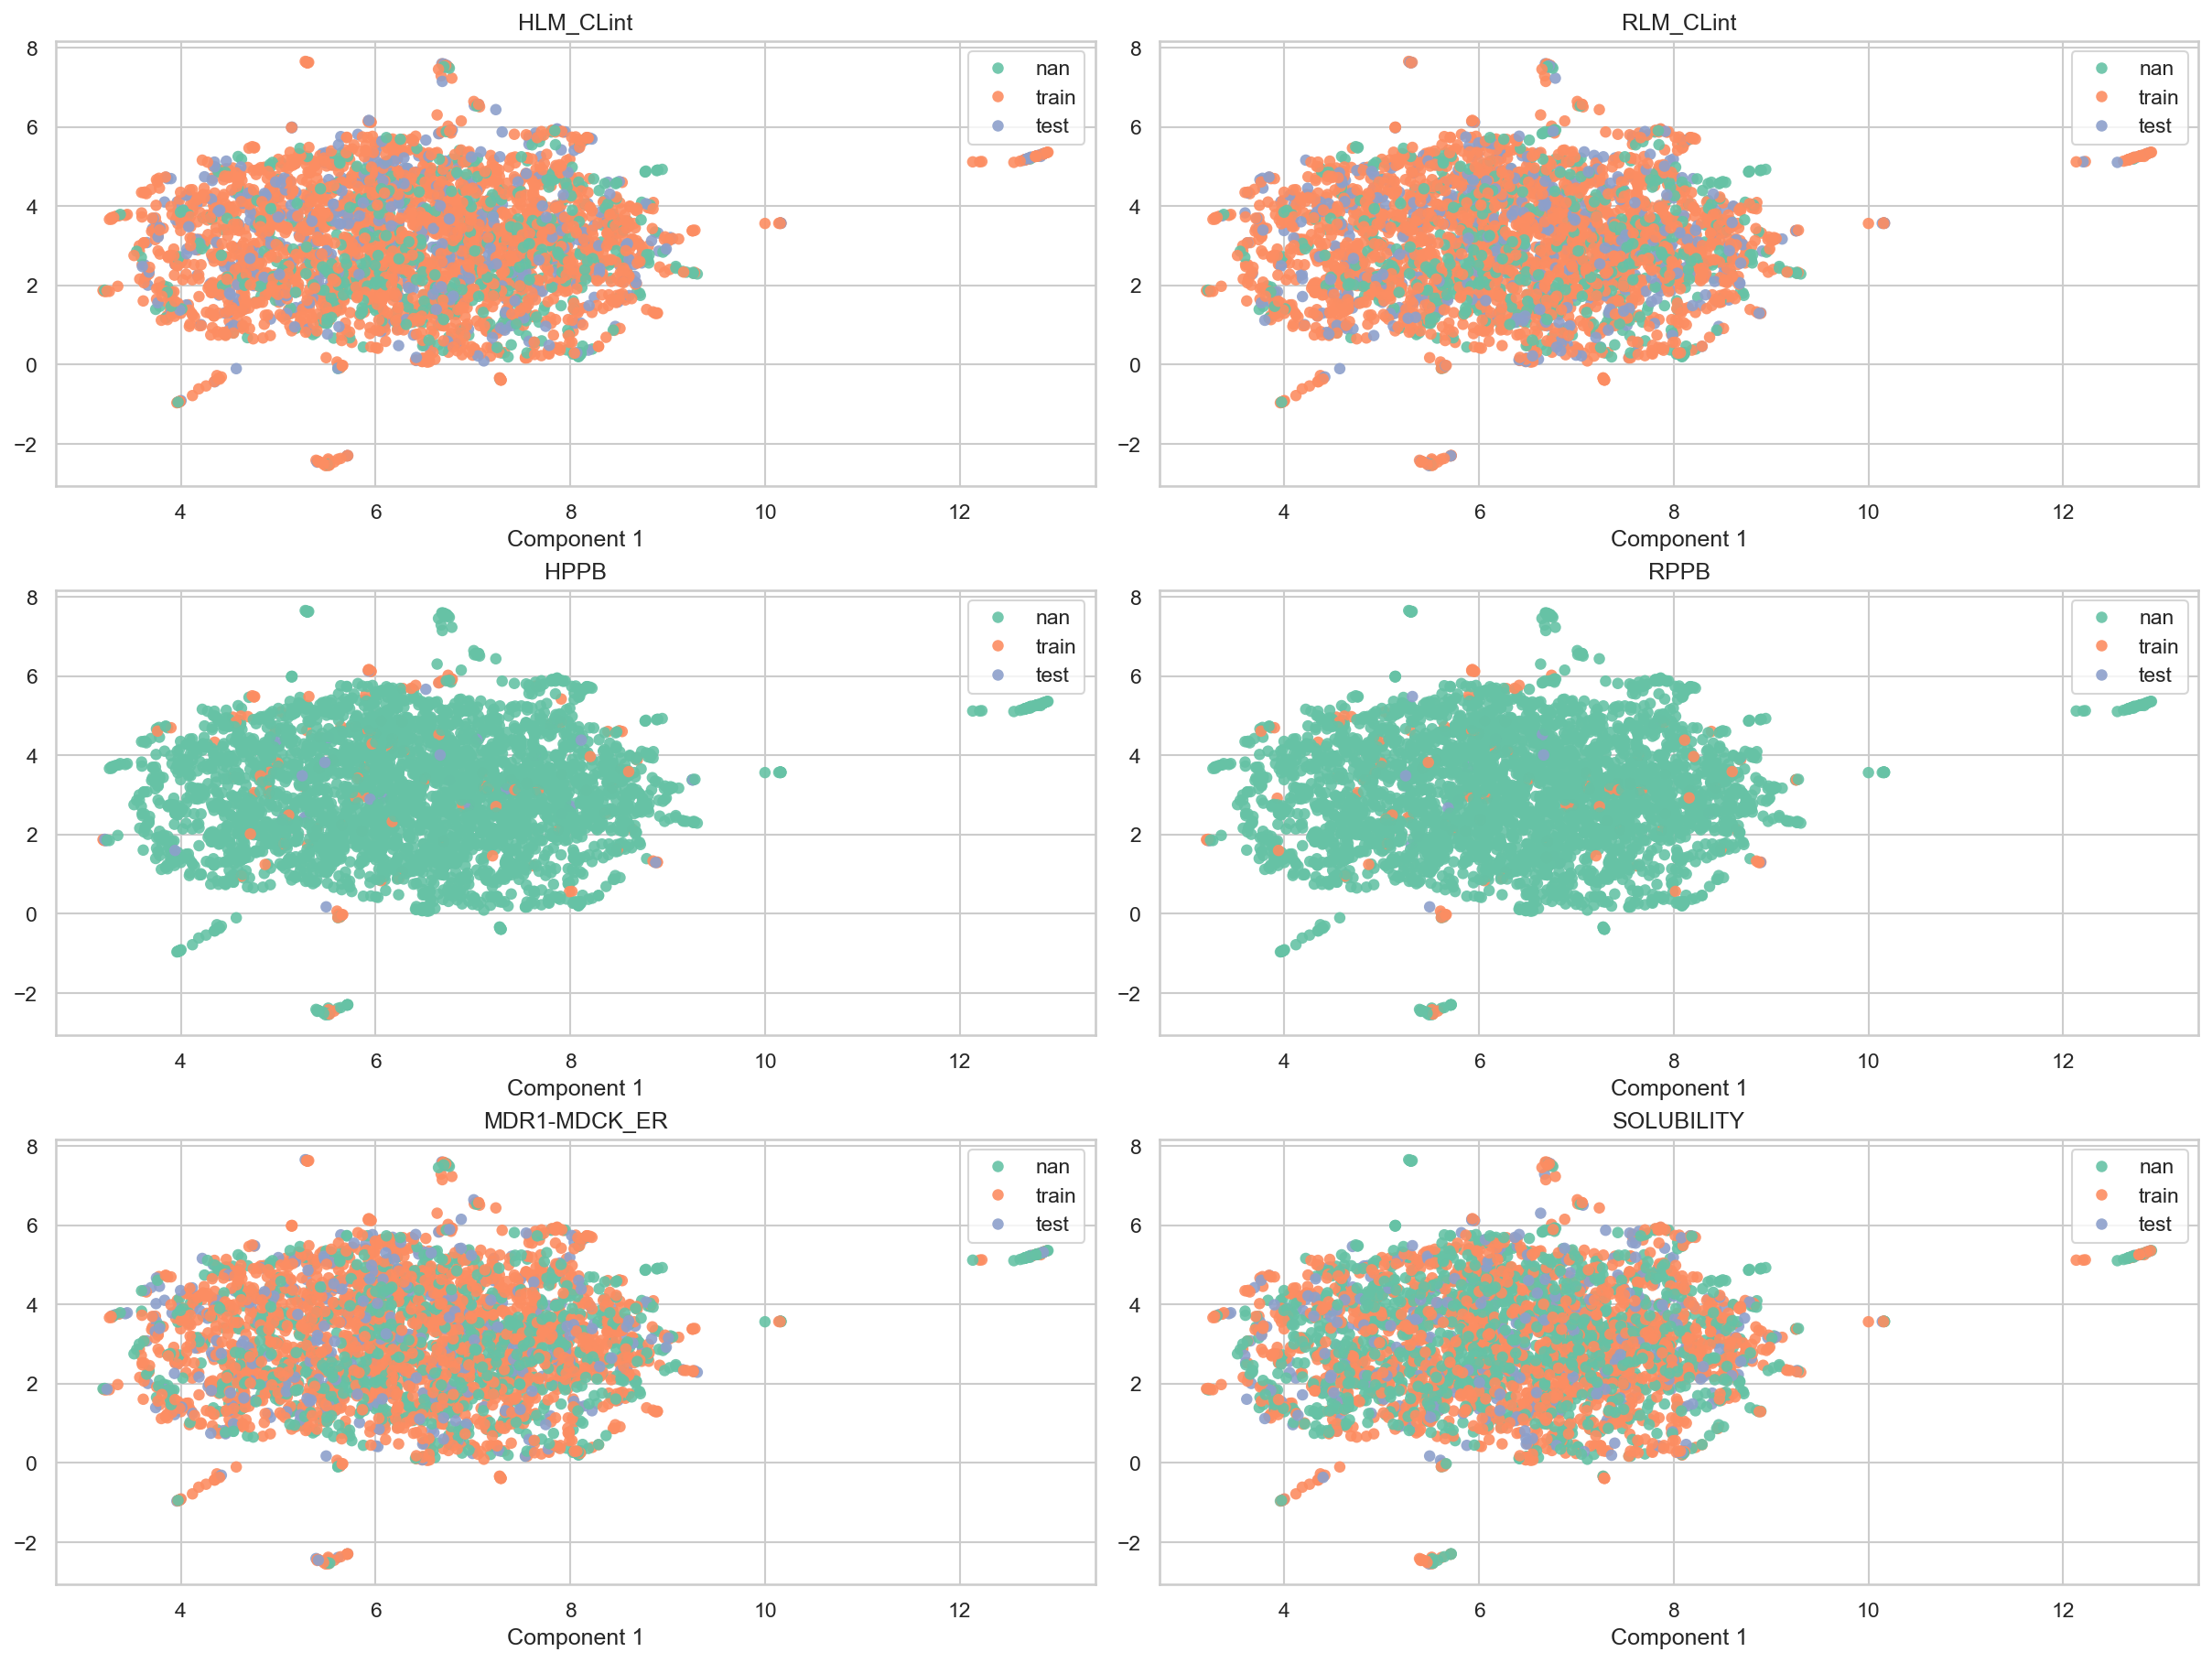

In [14]:
from utils.docs_utils import visualize_split_chemspace

mol_col = "MOL_smiles"

fig = visualize_split_chemspace(
    mols=table[mol_col].to_list(), train_test_dict=paper_splits
)

<div class="alert alert-block alert-warning"> <b>Attention:</b> The data points `nan` can not be found in `gs://polaris-public/Data/ADME/fang2023/MPNN` splitting files. </div>

In [15]:
# export the figure to remote path
from utils.auroris_utils import save_image

save_image(fig, dm.fs.join(FIGURE_DIR, f"{split_key}_chemspace.png"))

'https://storage.googleapis.com/polaris-public/polaris-recipes/org-biogen/fang2023_ADME/figures/fang2023split_chemspace.png'

## Create a benchmark for Fang et al. 2023 dataset
### The train/test sets are pre-defined from fang et al. 2023 

In [16]:
benchmark_version = "v1"

In [22]:
benchmark_path = {}
data_cols = [
    "LOG_HLM_CLint",
    "LOG_RLM_CLint",
    "LOG_MDR1-MDCK_ER",
    "LOG_HPPB",
    "LOG_RPPB",
    "LOG_SOLUBILITY",
]

split_key = "fang2023_split"

benchmark_names = [
    "adme-fang-HCLint_reg",
    "adme-fang-RCLint_reg",
    "adme-fang-PERM_reg",
    "adme-fang-HPPB_reg",
    "adme-fang-RPPB_reg",
    "adme-fang-SOLU_reg",
]

for target_col, benchmark_name in zip(data_cols, benchmark_names):
    benchmark_name = f"{benchmark_name}-{benchmark_version}"
    readme_name = f"fang2023_ADME_public_single_reg_{target_col}_v1"
    benchmark = SingleTaskBenchmarkSpecification(
        name=benchmark_name,
        dataset=dataset,
        target_cols=target_col,
        target_type="regression",
        input_cols=[mol_col],
        split=paper_splits[target_col[4:]],
        main_metric="pearsonr",  # fang et al. 2023 use the `pearsonr` for performance evalution
        metrics=[
            "mean_absolute_error",
            "mean_squared_error",
            "r2",
            "spearmanr",
            "pearsonr",
            "explained_var",
        ],
        tags=["adme", "singletask"],
        owner=owner,
        description=f"Single task benchmark for ADME property {target_col}",
        readme=load_readme(
            f"org-Biogen/fang2023_ADME/benchmarks/{readme_name}_readme.md"
        ),
    )
    BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
    path = benchmark.to_json(BENCHMARK_SAVE_DIR)
    print(path)

    # upload to polaris hub
    # client.upload_benchmark(benchmark=benchmark, access="public", owner=owner)

2024-07-15 23:01:25.521 | INFO     | polaris._mixins:md5sum:27 - Computing the checksum. This can be slow for large datasets.
2024-07-15 23:01:27.556 | INFO     | polaris._mixins:md5sum:27 - Computing the checksum. This can be slow for large datasets.


gs://polaris-public/polaris-recipes/org-biogen/fang2023_ADME/benchmarks/adme-fang-HCLint_reg-v1/benchmark.json


2024-07-15 23:01:29.680 | INFO     | polaris._mixins:md5sum:27 - Computing the checksum. This can be slow for large datasets.


gs://polaris-public/polaris-recipes/org-biogen/fang2023_ADME/benchmarks/adme-fang-RCLint_reg-v1/benchmark.json


2024-07-15 23:01:31.509 | INFO     | polaris._mixins:md5sum:27 - Computing the checksum. This can be slow for large datasets.


gs://polaris-public/polaris-recipes/org-biogen/fang2023_ADME/benchmarks/adme-fang-PERM_reg-v1/benchmark.json


2024-07-15 23:01:33.389 | INFO     | polaris._mixins:md5sum:27 - Computing the checksum. This can be slow for large datasets.


gs://polaris-public/polaris-recipes/org-biogen/fang2023_ADME/benchmarks/adme-fang-HPPB_reg-v1/benchmark.json


2024-07-15 23:01:35.579 | INFO     | polaris._mixins:md5sum:27 - Computing the checksum. This can be slow for large datasets.


gs://polaris-public/polaris-recipes/org-biogen/fang2023_ADME/benchmarks/adme-fang-RPPB_reg-v1/benchmark.json
gs://polaris-public/polaris-recipes/org-biogen/fang2023_ADME/benchmarks/adme-fang-SOLU_reg-v1/benchmark.json
